In [115]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from kneed import KneeLocator
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
import shap

from scipy.stats import kruskal, f_oneway
from statsmodels.stats.multitest import multipletests

from ucimlrepo import fetch_ucirepo
air_quality = fetch_ucirepo(id=360) 

# X = air_quality.data.features

vars_df = pd.DataFrame(air_quality.variables)
pd.set_option('display.max_colwidth', 200)

#drop useless columns
vars_df = vars_df.drop(columns=['demographic', 'missing_values'], errors='ignore')

display(vars_df.style.set_properties(subset=['description'], **{'text-align': 'left'}))

df = pd.DataFrame(air_quality.data.features)
df.head()

,name,role,type,description,units
0,Date,Feature,Date,None,None
1,Time,Feature,Categorical,None,None
2,CO(GT),Feature,Integer,True hourly averaged concentration CO in mg/m^3 (reference analyzer),mg/m^3
3,PT08.S1(CO),Feature,Categorical,hourly averaged sensor response (nominally CO targeted),None
4,NMHC(GT),Feature,Integer,True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer),microg/m^3
5,C6H6(GT),Feature,Continuous,True hourly averaged Benzene concentration in microg/m^3 (reference analyzer),microg/m^3
6,PT08.S2(NMHC),Feature,Categorical,hourly averaged sensor response (nominally NMHC targeted),None
7,NOx(GT),Feature,Integer,True hourly averaged NOx concentration in ppb (reference analyzer),ppb
8,PT08.S3(NOx),Feature,Categorical,hourly averaged sensor response (nominally NOx targeted),None
9,NO2(GT),Feature,Integer,True hourly averaged NO2 concentration in microg/m^3 (reference analyzer),microg/m^3


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


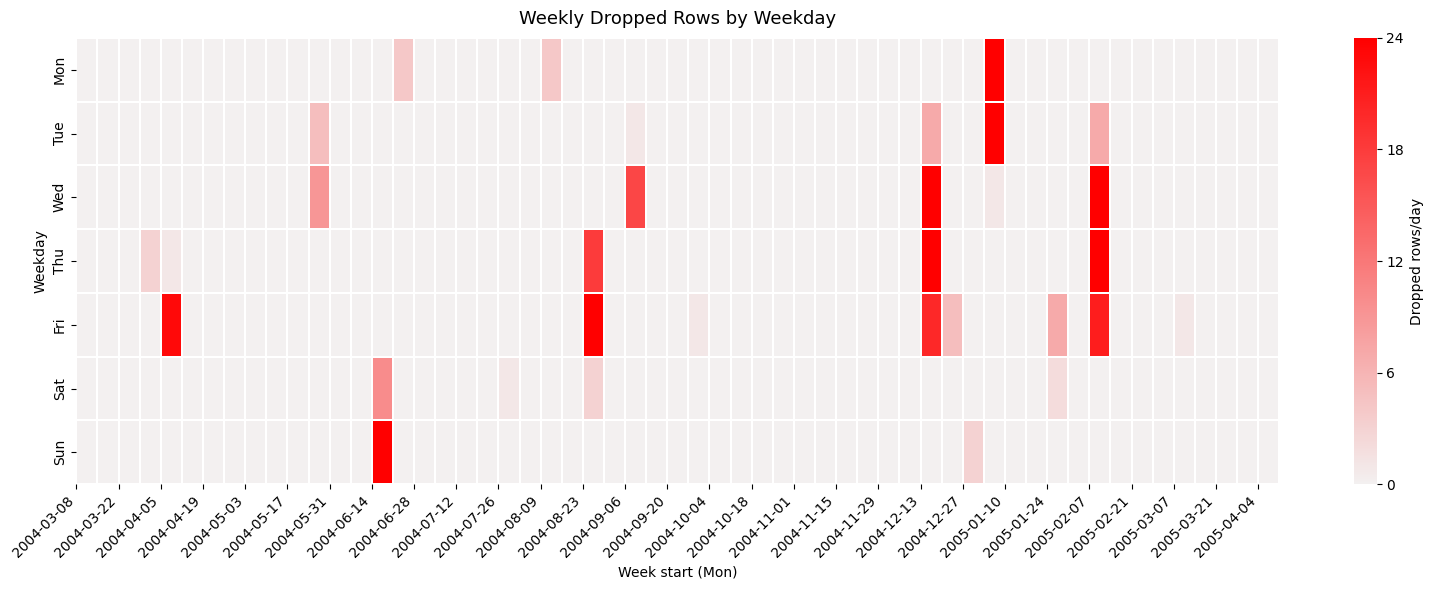

In [90]:
# Weekly heatmap of dropped rows (weekday × week)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mask_missing_any = (df[features] == -200).any(axis=1)
_dt = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
mask_missing_any &= ~_dt.isna()

_tmp = pd.DataFrame({'date': _dt.dt.date, 'missing': mask_missing_any.astype(int)}).dropna(subset=['date'])
missing_per_day = _tmp.groupby('date')['missing'].sum().sort_index()

daily = pd.DataFrame({'date': pd.to_datetime(missing_per_day.index), 'missing': missing_per_day.values})
daily['weekday'] = daily['date'].dt.weekday  # 0=Mon..6=Sun
daily['week_start'] = daily['date'] - pd.to_timedelta(daily['weekday'], unit='D')
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily['weekday_name'] = daily['weekday'].map(dict(enumerate(weekday_names)))

heat = daily.pivot_table(index='weekday_name', columns='week_start', values='missing', aggfunc='sum', fill_value=0)
heat = heat.reindex(index=weekday_names).sort_index(axis=1)

vmin, vmax = 0, 24
cmap_light_red = sns.light_palette("red", n_colors=256, as_cmap=True)

plt.figure(figsize=(16, 6))
ax = sns.heatmap(
    heat,
    cmap=cmap_light_red,
    vmin=vmin, vmax=vmax,
    cbar=True,
    cbar_kws={'label': 'Dropped rows/day', 'ticks': [0, 6, 12, 18, 24]},
    linewidths=0.2,
    linecolor='white'
)
ax.set_title('Weekly Dropped Rows by Weekday', fontsize=13, pad=10)
ax.set_xlabel('Week start (Mon)')
ax.set_ylabel('Weekday')

n_cols = heat.shape[1]
if n_cols > 24:
    step = max(1, n_cols // 24)
    ax.set_xticks(np.arange(0, n_cols, step))
    ax.set_xticklabels([str(pd.to_datetime(heat.columns[i]).date()) for i in range(0, n_cols, step)], rotation=45, ha='right')
else:
    ax.set_xticklabels([str(pd.to_datetime(c).date()) for c in heat.columns], rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [91]:
# Select relevant features and clean data
features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 
            'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
X = df[features]
X = X.replace(-200, np.nan).dropna()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



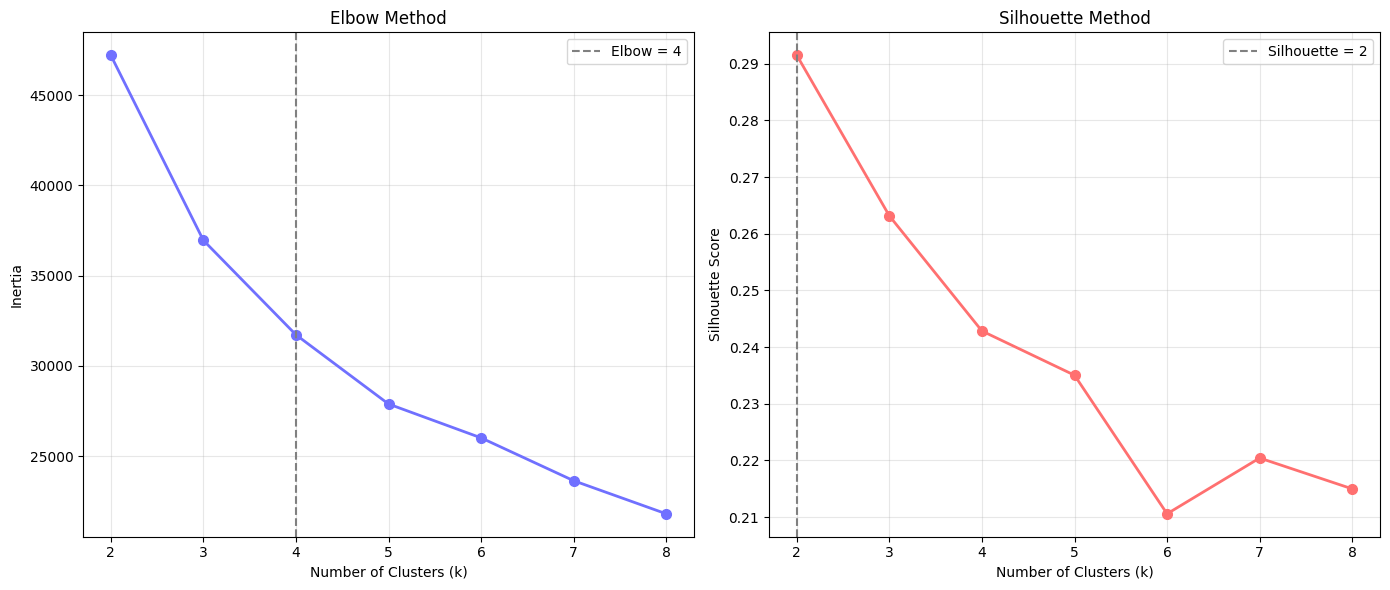

In [92]:
# Elbow method vs Silhouette method
K_values = range(2, 9)
inertias = []
silhouette_scores = []

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

elbow_kneedle = KneeLocator(K_values, inertias, curve='convex', direction='decreasing')
elbow_point = elbow_kneedle.elbow

silhouette_kneedle = KneeLocator(K_values, silhouette_scores, curve='concave', direction='increasing')
silhouette_point = silhouette_kneedle.elbow

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Elbow Method
axes[0].plot(K_values, inertias, marker='o', color='#7070ff', linewidth=2, markersize=7)
axes[0].axvline(x=elbow_point, color='grey', linestyle='--', linewidth=1.5, label=f'Elbow = {elbow_point}')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Silhouette Method
axes[1].plot(K_values, silhouette_scores, marker='o', color='#ff7070', linewidth=2, markersize=7)
axes[1].axvline(x=silhouette_point, color='grey', linestyle='--', linewidth=1.5, label=f'Silhouette = {silhouette_point}')
axes[1].set_title('Silhouette Method')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

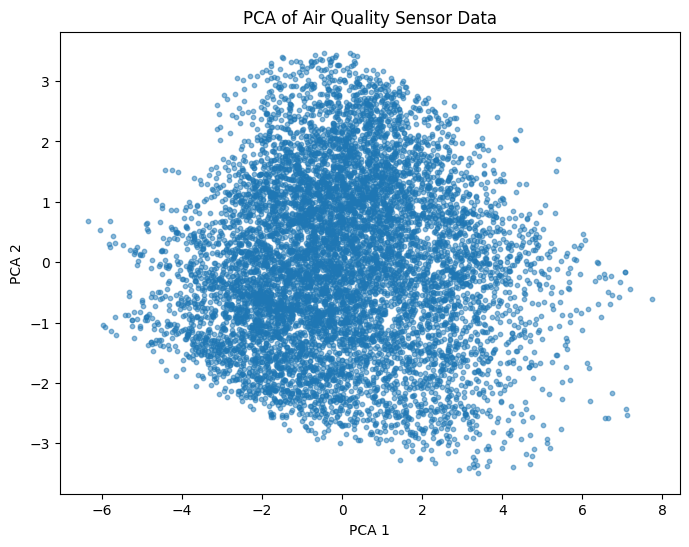

In [93]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Air Quality Sensor Data')
plt.show()



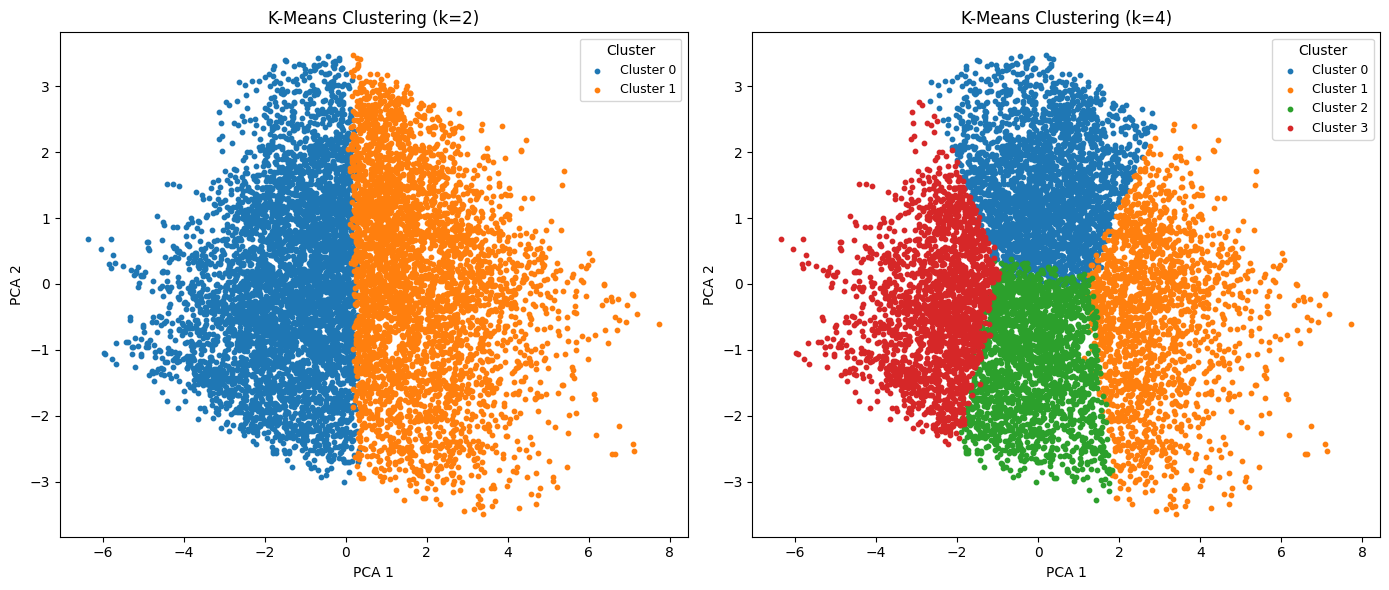

In [94]:
kmeans2 = KMeans(n_clusters=2, random_state=42)
labels2 = kmeans2.fit_predict(X_scaled)

kmeans4 = KMeans(n_clusters=4, random_state=42)
labels4 = kmeans4.fit_predict(X_scaled)

# --- Color palettes ---
colors2 = plt.cm.tab10(np.arange(2))
colors4 = plt.cm.tab10(np.arange(4))

# --- Create side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ===== Left: k=2 =====
for i, color in zip(range(2), colors2):
    axes[0].scatter(
    X_pca[labels2 == i, 0],
    X_pca[labels2 == i, 1],
    s=10, color=color, label=f'Cluster {i}'
    )
axes[0].set_title('K-Means Clustering (k=2)')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')
axes[0].legend(title='Cluster', loc='best', fontsize=9)

# ===== Right: k=4 =====
for i, color in zip(range(4), colors4):
    axes[1].scatter(
        X_pca[labels4 == i, 0],
        X_pca[labels4 == i, 1],
        s=10, color=color, label=f'Cluster {i}'
    )
axes[1].set_title('K-Means Clustering (k=4)')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')
axes[1].legend(title='Cluster', loc='best', fontsize=9)

plt.tight_layout()
plt.show()

In [95]:
transition_counts = np.zeros((2, 4), dtype=int)
for i in range(len(labels2)):
    transition_counts[labels2[i], labels4[i]] += 1

labels_nodes = [f'k2_C{i}' for i in range(2)] + [f'k4_C{i}' for i in range(4)]

base_colors = {
    'lilla': (170/255, 110/255, 200/255),
    'blue':  (31/255, 119/255, 180/255),
    'orange':(255/255, 127/255, 14/255),
    'green': (44/255, 160/255, 44/255),
    'red':   (214/255, 39/255, 40/255)
}

node_colors = [
    f'rgba({int(base_colors["lilla"][0]*255)}, {int(base_colors["lilla"][1]*255)}, {int(base_colors["lilla"][2]*255)}, 0.9)',
    f'rgba({int(base_colors["lilla"][0]*255)}, {int(base_colors["lilla"][1]*255)}, {int(base_colors["lilla"][2]*255)}, 0.9)',
    f'rgba({int(base_colors["blue"][0]*255)}, {int(base_colors["blue"][1]*255)}, {int(base_colors["blue"][2]*255)}, 0.9)',
    f'rgba({int(base_colors["orange"][0]*255)}, {int(base_colors["orange"][1]*255)}, {int(base_colors["orange"][2]*255)}, 0.9)',
    f'rgba({int(base_colors["green"][0]*255)}, {int(base_colors["green"][1]*255)}, {int(base_colors["green"][2]*255)}, 0.9)',
    f'rgba({int(base_colors["red"][0]*255)}, {int(base_colors["red"][1]*255)}, {int(base_colors["red"][2]*255)}, 0.9)',
]

def pastelize(rgb, factor=0.4):
    r, g, b = rgb
    r = r * factor + (1 - factor)
    g = g * factor + (1 - factor)
    b = b * factor + (1 - factor)
    return f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.5)'

sources, targets, values, link_colors = [], [], [], []
for i in range(2):
    for j in range(4):
        if transition_counts[i, j] > 0:
            sources.append(i)
            targets.append(2 + j)
            values.append(transition_counts[i, j])
            link_colors.append(pastelize(base_colors["lilla"], factor=0.4))

fig_sankey = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=25,
        thickness=20,
        line=dict(color="rgba(0,0,0,0.3)", width=0.5),
        label=labels_nodes,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors
    )
)])

fig_sankey.update_layout(
    title_text="Evolution of K-means (k=2 → k=4)",
    font=dict(size=12, color='black'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig_sankey.show()

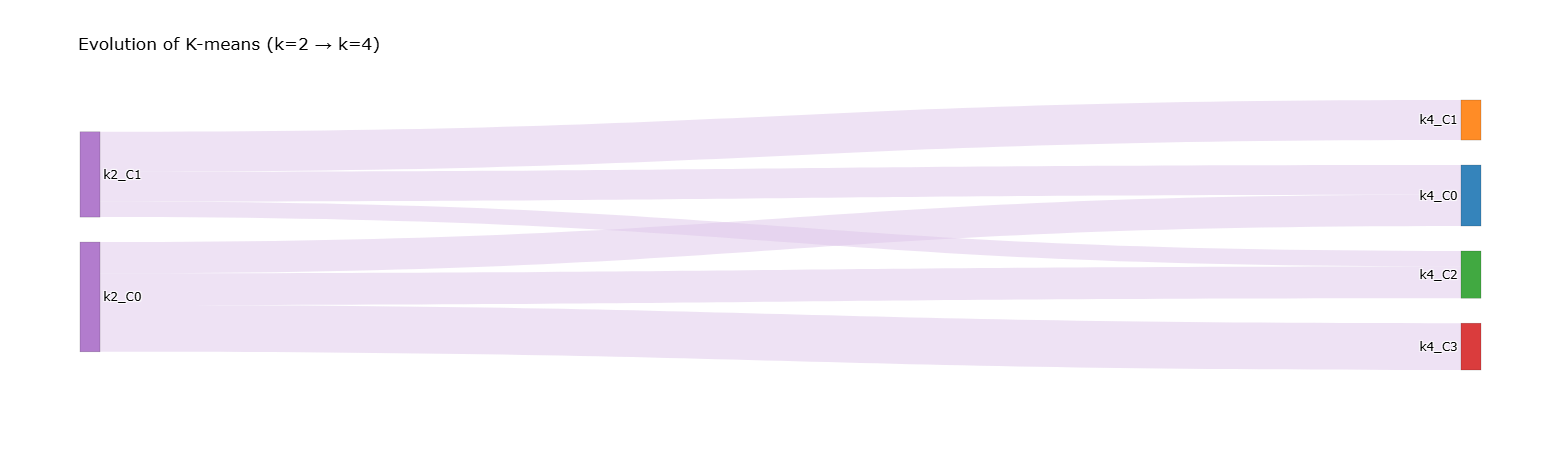

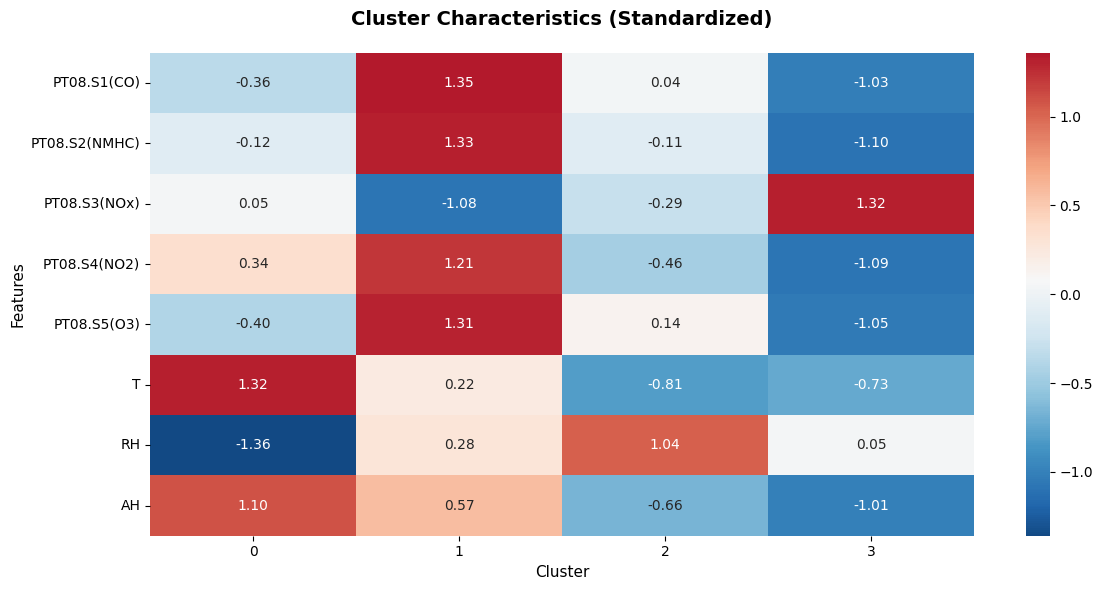

In [96]:
# Cluster characteristics heatmap (standardized)
base_cmap = plt.get_cmap('RdBu_r')
colors = base_cmap(np.linspace(0.05, 0.9, 256))
soft_rd_bu = LinearSegmentedColormap.from_list('soft_rd_bu', colors)

df_clean = X.copy()
df_clean['cluster'] = labels4
cluster_summary = df_clean.groupby('cluster')[features].mean()
cluster_summary_scaled = (cluster_summary - cluster_summary.mean()) / cluster_summary.std()
cluster_summary_scaled_T = cluster_summary_scaled.T

vmax = np.nanmax(np.abs(cluster_summary_scaled_T.values))

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    cluster_summary_scaled_T,
    annot=True,
    fmt='.2f',
    cmap=soft_rd_bu,
    center=0,
    vmin=-vmax, vmax=vmax,
    ax=ax
)
ax.set_title('Cluster Characteristics (Standardized)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Features', fontsize=11)
plt.tight_layout()
plt.show()

In [97]:
# summary statistics

def print_summary_table(df_summary):
    # function to style output like a table - statistics output
    BOLD = '\033[1m'
    END = '\033[0m'

    features = df_summary.columns.levels[0]
    stats = df_summary.columns.levels[1]

    col_width = 10
    extra_spaces = 3

    top_header = ""
    for feature in features:
        total_width = col_width * len(stats) + (len(stats)-1)*3
        top_header += feature.center(total_width) + "   "

    second_header = " " * extra_spaces
    for _ in features:
        for stat in stats:
            second_header += stat.center(col_width) + "   "

    print(f"{BOLD}{'cluster'.ljust(8)}{top_header}{END}")
    print(f"{BOLD}{''.ljust(8)}{second_header}{END}")

    for cluster, row in df_summary.iterrows():
        print(str(cluster).ljust(8), end=" ")
        for feature in features:
            for stat in stats:
                val = row[(feature, stat)]
                print(f"{val:>{col_width}.2f}", end="   ")
        print()

summary_stats = df_clean.groupby('cluster')[features].agg(['mean', 'std', 'median'])
print_summary_table(summary_stats)

cluster             PT08.S1(CO)                           PT08.S2(NMHC)                           PT08.S3(NOx)                           PT08.S4(NO2)                           PT08.S5(O3)                                 T                                      RH                                     AH                    
              mean         std         median        mean         std         median        mean         std         median        mean         std         median        mean         std         median        mean         std         median        mean         std         median        mean         std         median     
0           1035.40       117.86      1034.00       922.31       157.12       925.00       838.30       134.74       827.00      1576.25       159.37      1572.00       889.32       216.78       881.00        27.35         5.80        26.20        38.25        15.18        36.60         1.30         0.35         1.28   
1           1420.63       148.92 

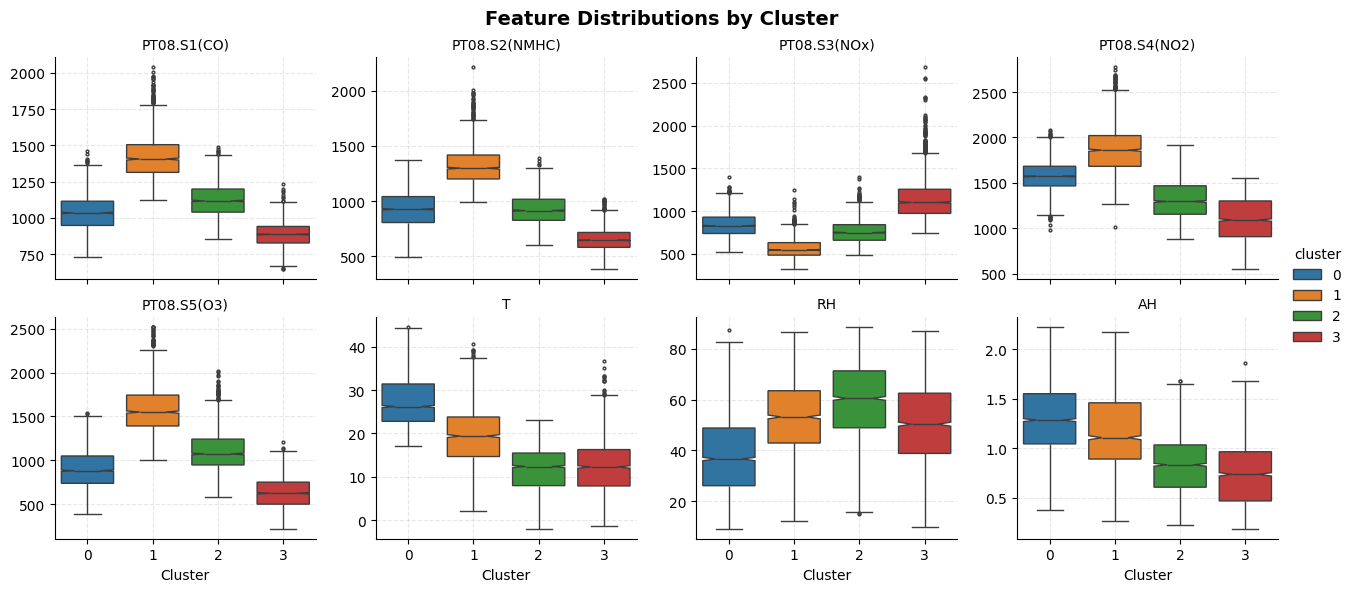

In [98]:
_df = df_clean.copy()
_df['cluster'] = _df['cluster'].astype(int)
df_long = _df.melt(
    id_vars=['cluster'],
    value_vars=features,
    var_name='Feature',
    value_name='Value'
)

# Order clusters numerically
cluster_order = sorted(_df['cluster'].unique())

# Faceted box plots by feature
g = sns.catplot(
    data=df_long,
    x='cluster', y='Value',
    col='Feature', col_wrap=4,
    order=cluster_order,
    kind='box',
    sharey=False,
    height=3, aspect=1.1,
    fliersize=2,
    palette='tab10',
    hue='cluster',
    notch=True
)

g.set_titles('{col_name}')
g.set_axis_labels('Cluster', '')
for ax in g.axes.flat:
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xlabel('Cluster')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Feature Distributions by Cluster', fontsize=14, fontweight='bold')
plt.show()

In [99]:
BOLD = '\033[1m'
END = '\033[0m'

def print_table(df, feature_col='Feature', float_format="{:.3f}"):
  # function to style output like a table - other output
    col_widths = []
    for col in df.columns:
        if col == feature_col:
            max_len = max(df[col].astype(str).map(len).max(), len(str(col)))
        else:
            formatted_data = df[col].apply(lambda x: float_format.format(x) if isinstance(x, float) else str(x))
            max_len = max(formatted_data.map(len).max(), len(str(col)))
        col_widths.append(max_len + 4)
    for i, col in enumerate(df.columns):
        print(BOLD + str(col).center(col_widths[i]) + END, end='')
    print()
    for _, row in df.iterrows():
        for i, col in enumerate(df.columns):
            val = row[col]
            if col == feature_col:
                val_str = str(val)
                print(val_str.ljust(col_widths[i]), end='')
            else:
                if isinstance(val, float):
                    val_str = float_format.format(val)
                else:
                    val_str = str(val)
                print(val_str.center(col_widths[i]), end='')
        print()

In [111]:
# statistical tests
anova_results = []
kruskal_results = []

for feature in features:
    groups = [df_clean[df_clean['cluster'] == k][feature] for k in sorted(df_clean['cluster'].unique())]
    # ANOVA test
    f_stat, p_anova = f_oneway(*groups)
    # Kruskal-Wallis test
    h_stat, p_kruskal = kruskal(*groups)

    grand_mean = df_clean[feature].mean()
    ss_between = sum(len(g)*(g.mean() - grand_mean)**2 for g in groups)
    ss_total = sum((df_clean[feature] - grand_mean)**2)
    eta_squared = ss_between / ss_total

    anova_results.append((feature, f_stat, p_anova, eta_squared))
    kruskal_results.append((feature, h_stat, p_kruskal))

# results
anova_df = pd.DataFrame(anova_results, columns=['Feature', 'F-stat', 'p-value', 'Eta²'])
kruskal_df = pd.DataFrame(kruskal_results, columns=['Feature', 'H-stat', 'p-value'])
# Bonferroni correction
anova_df['p-adjusted'] = multipletests(anova_df['p-value'], method='bonferroni')[1]
kruskal_df['p-adjusted'] = multipletests(kruskal_df['p-value'], method='bonferroni')[1]

print(f"\n{BOLD}ANOVA results:{END}")
print()
anova_sorted = anova_df.sort_values('p-adjusted').reset_index(drop=True)
print_table(anova_sorted)
print()
print(f"\n{BOLD}Kruskal-Wallis results:{END}")
print()
kruskal_sorted = kruskal_df.sort_values('p-adjusted').reset_index(drop=True)
print_table(kruskal_sorted)



ANOVA results:

     Feature        F-stat     p-value     Eta²    p-adjusted  
PT08.S1(CO)        7516.242     0.000     0.715      0.000     
PT08.S2(NMHC)      7293.557     0.000     0.709      0.000     
PT08.S3(NOx)       4458.327     0.000     0.598      0.000     
PT08.S4(NO2)       5083.664     0.000     0.629      0.000     
PT08.S5(O3)        6770.782     0.000     0.693      0.000     
T                  4035.086     0.000     0.574      0.000     
RH                 824.365      0.000     0.216      0.000     
AH                 1525.473     0.000     0.337      0.000     


Kruskal-Wallis results:

     Feature        H-stat     p-value    p-adjusted  
PT08.S1(CO)        6287.700     0.000       0.000     
PT08.S2(NMHC)      6292.597     0.000       0.000     
PT08.S3(NOx)       5803.227     0.000       0.000     
PT08.S4(NO2)       5911.403     0.000       0.000     
PT08.S5(O3)        6212.575     0.000       0.000     
T                  5416.291     0.000       0.000 

## Multivariate Check: Predicting Cluster Labels with Random Forest


In [101]:
# Prepare data for supervised prediction of cluster labels
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Use the same features used for clustering
X_rf = df_clean[features].copy()
y_rf = df_clean['cluster'].astype(int).copy()

# Train/validation split with stratification to preserve cluster proportions
X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42, stratify=y_rf
)

# Fit Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

print("Model trained: RandomForestClassifier")

Model trained: RandomForestClassifier


Accuracy: 0.97
Macro F1: 0.97

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       563
           1       0.96      0.96      0.96       369
           2       0.97      0.95      0.96       435
           3       0.98      0.97      0.97       432

    accuracy                           0.97      1799
   macro avg       0.97      0.97      0.97      1799
weighted avg       0.97      0.97      0.97      1799



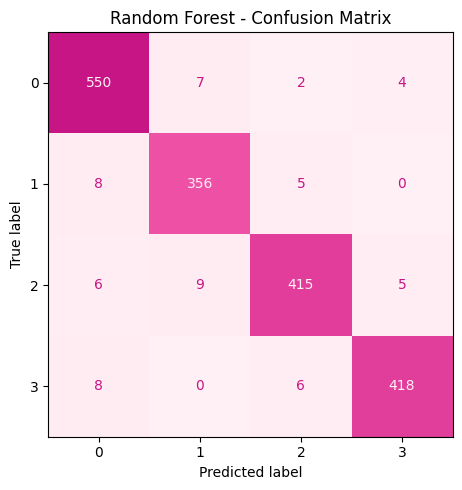

In [112]:
# Evaluate performance
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc:.2f}")
print(f"Macro F1: {macro_f1:.2f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=2))

pink_cmap = LinearSegmentedColormap.from_list("soft_pink", ["#fff0f5", "#ff69b4", "#c71585"])

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, ax=ax, cmap=pink_cmap, colorbar=False)
ax.set_title('Random Forest - Confusion Matrix')
plt.tight_layout()
plt.show()

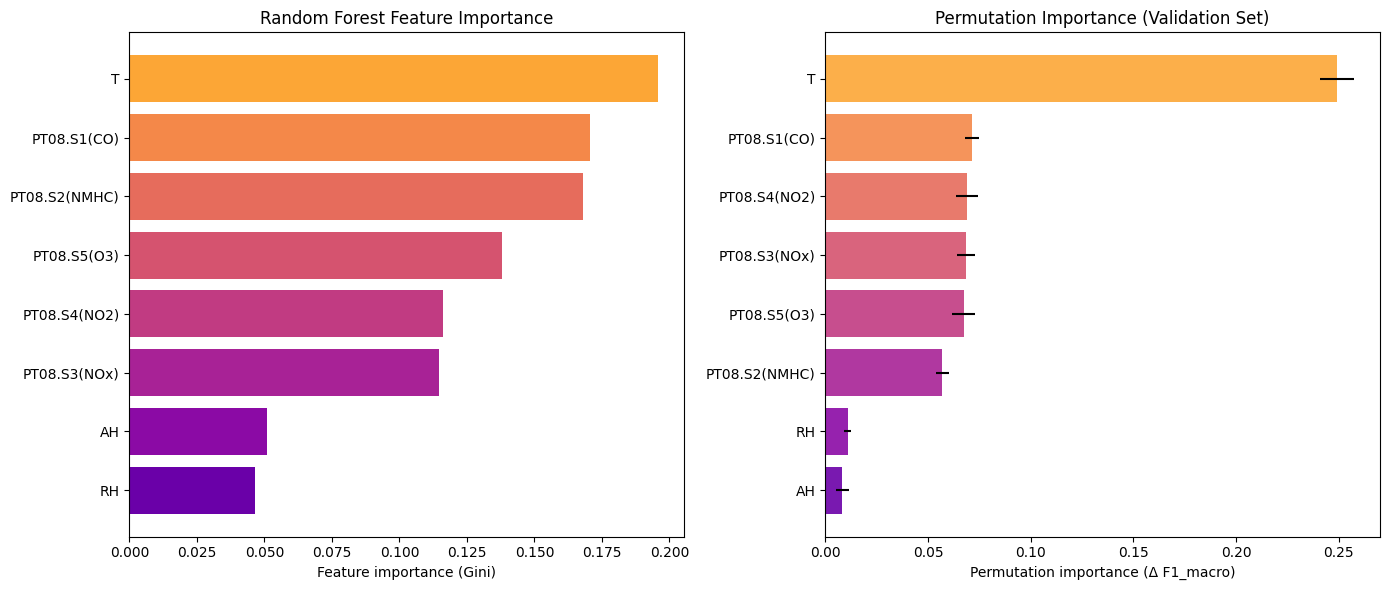

In [113]:
from sklearn.inspection import permutation_importance
# Gini importance
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)

# Permutation importance
perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='f1_macro'
)
perm_importances = pd.Series(perm.importances_mean, index=features).sort_values(ascending=True)
perm_err = pd.Series(perm.importances_std, index=features).loc[perm_importances.index]

# Plasma color palette
plasma = plt.get_cmap('plasma')
colors_gini = plasma(np.linspace(0.2, 0.8, len(importances)))
colors_perm = plasma(np.linspace(0.2, 0.8, len(perm_importances)))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].barh(importances.index, importances.values, color=colors_gini)
axes[0].set_xlabel('Feature importance (Gini)')
axes[0].set_title('Random Forest Feature Importance')

axes[1].barh(perm_importances.index, perm_importances.values, xerr=perm_err.values, color=colors_perm, alpha=0.9)
axes[1].set_xlabel('Permutation importance (Δ F1_macro)')
axes[1].set_title('Permutation Importance (Validation Set)')

plt.tight_layout()
plt.show()

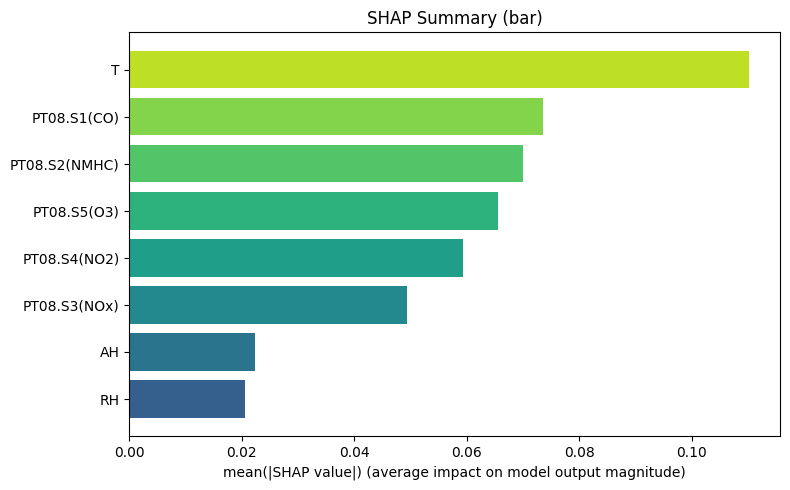

In [116]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Calculate mean absolute SHAP values for each feature
# Shape: (n_samples, n_features, n_classes) -> we want (n_features,)
mean_shap = np.abs(shap_values).mean(axis=(0, 2))  # Average over samples and classes

# Sort features by importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': mean_shap
}).sort_values('importance', ascending=True)

# Create viridis colors
viridis_colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(features)))

plt.figure(figsize=(8, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'], color=viridis_colors)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)')
plt.title('SHAP Summary (bar)')
plt.tight_layout()
plt.show()

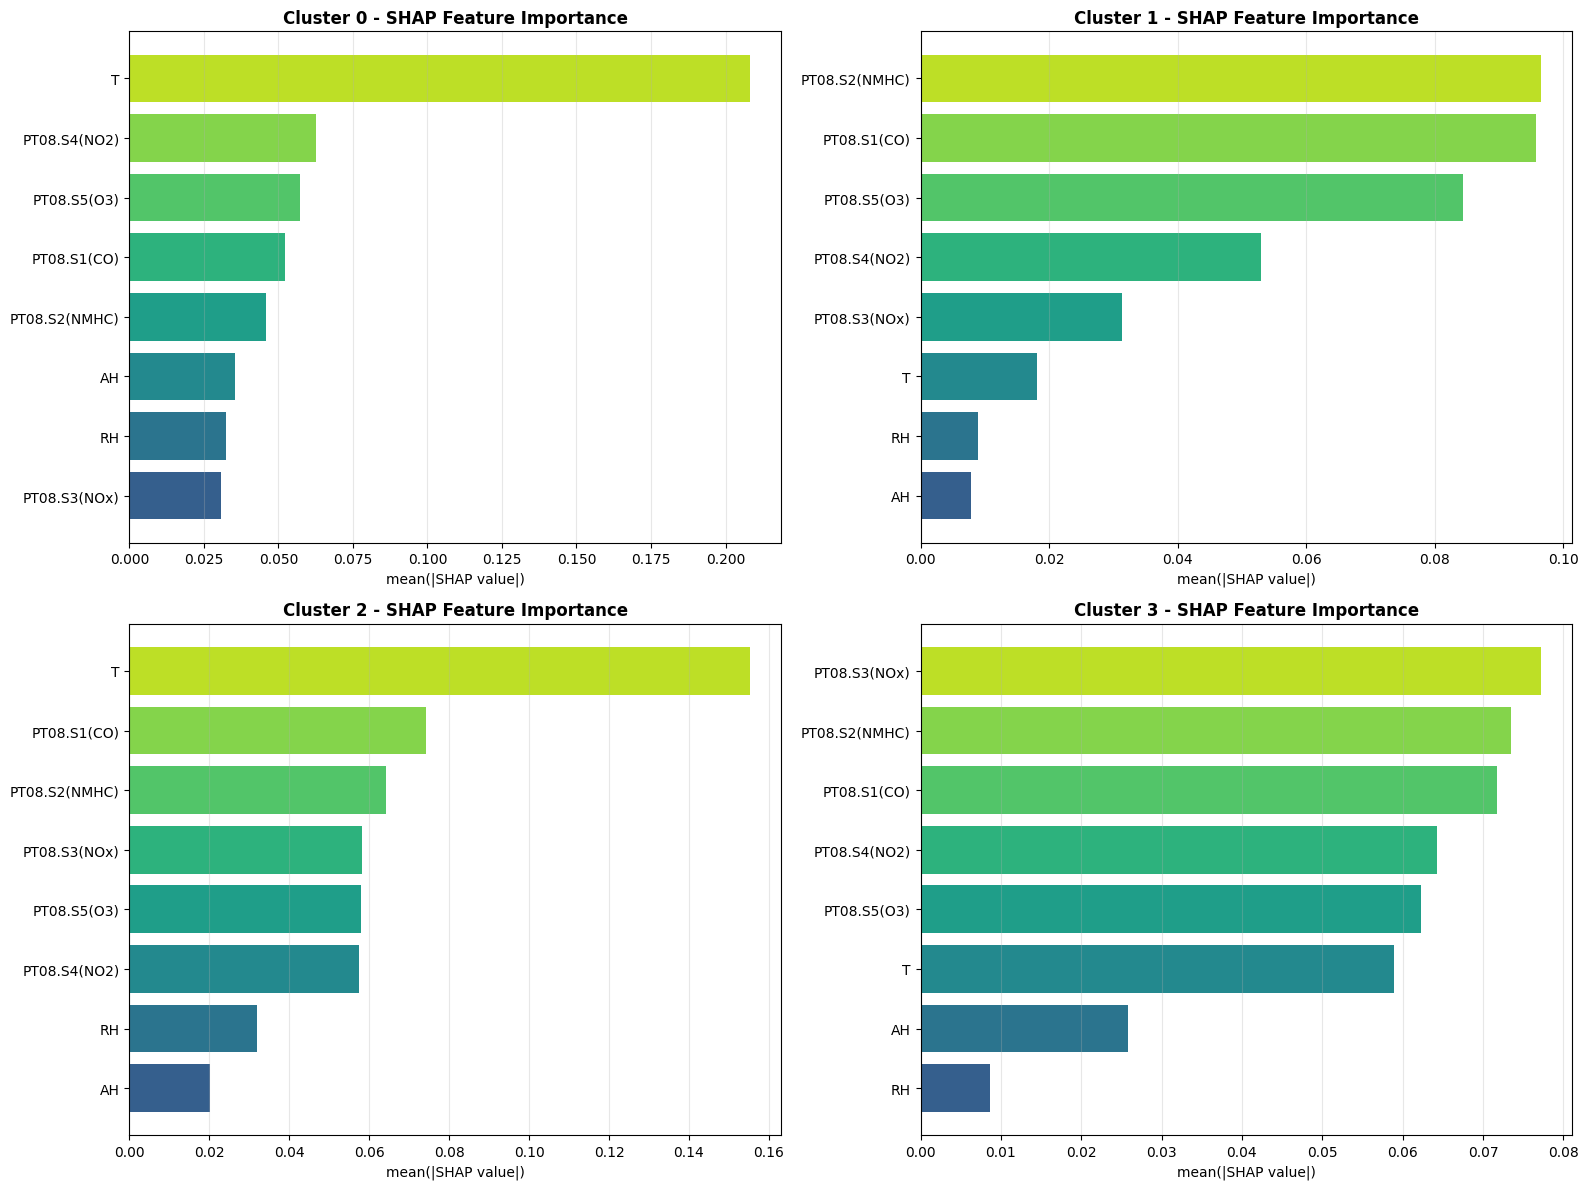

In [117]:
# SHAP graph for each cluster
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

n_clusters = shap_values.shape[2]

for cluster_idx in range(n_clusters):
    cluster_shap = np.abs(shap_values[:, :, cluster_idx]).mean(axis=0)

    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': cluster_shap
    }).sort_values('importance', ascending=False)

    feature_importance = feature_importance.sort_values('importance', ascending=True)

    viridis_colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(features)))

    axes[cluster_idx].barh(feature_importance['feature'], feature_importance['importance'], color=viridis_colors)
    axes[cluster_idx].set_xlabel('mean(|SHAP value|)')
    axes[cluster_idx].set_title(f'Cluster {cluster_idx} - SHAP Feature Importance', fontweight='bold')
    axes[cluster_idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

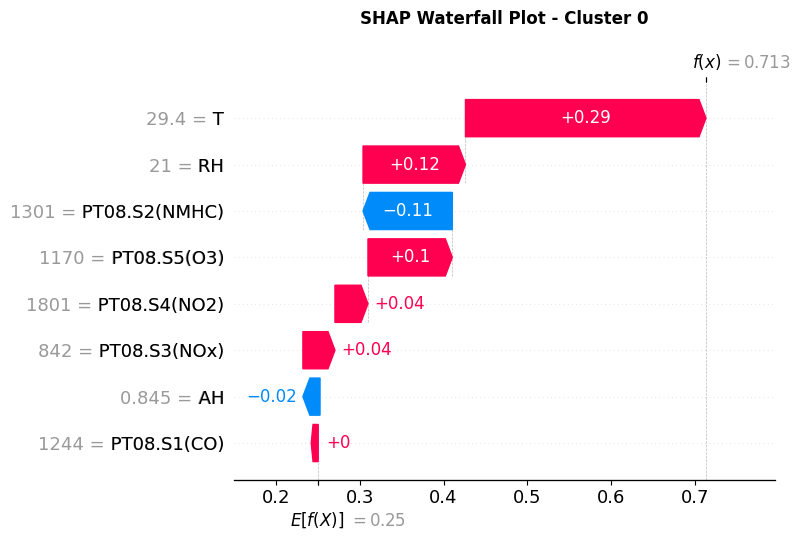

In [118]:
# SHAP Waterfall plot for Cluster 0
cluster_0_mask = y_test == 0
cluster_0_indices = y_test[cluster_0_mask].index

if len(cluster_0_indices) > 0:
    sample_idx = cluster_0_indices[0]
    sample_position = X_test.index.get_loc(sample_idx)

    shap_values_sample = shap_values[sample_position][:, 0]

    explanation = shap.Explanation(
        values=shap_values_sample,
        base_values=explainer.expected_value[0],
        data=X_test.iloc[sample_position].values,
        feature_names=features
    )

    plt.figure(figsize=(12, 10))
    shap.waterfall_plot(explanation, max_display=len(features), show=False)
    plt.title(f'SHAP Waterfall Plot - Cluster 0', fontsize=12, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("No samples from Cluster 0 found in test set")

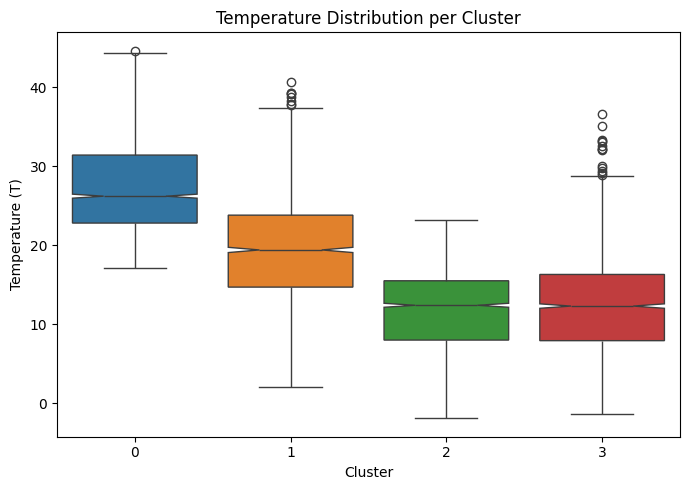

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure consistent cluster color mapping across plots
# Use string labels to match seaborn's expected palette keys
df_plot = df_clean.copy()
df_plot['cluster_str'] = df_plot['cluster'].astype(str)
clusters_str = sorted(df_plot['cluster_str'].unique(), key=lambda s: int(s))

cluster_colors = sns.color_palette('tab10', n_colors=len(clusters_str))
cluster_palette = {c: cluster_colors[i] for i, c in enumerate(clusters_str)}

plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    data=df_plot,
    x='cluster_str', y='T',
    order=clusters_str,
    hue='cluster_str',
    palette=cluster_palette,
    dodge=False,
    notch=True
)
# Remove redundant legend (since hue == x)
leg = ax.get_legend()
if leg is not None:
    leg.remove()

plt.title('Temperature Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Temperature (T)')
plt.tight_layout()
plt.show()

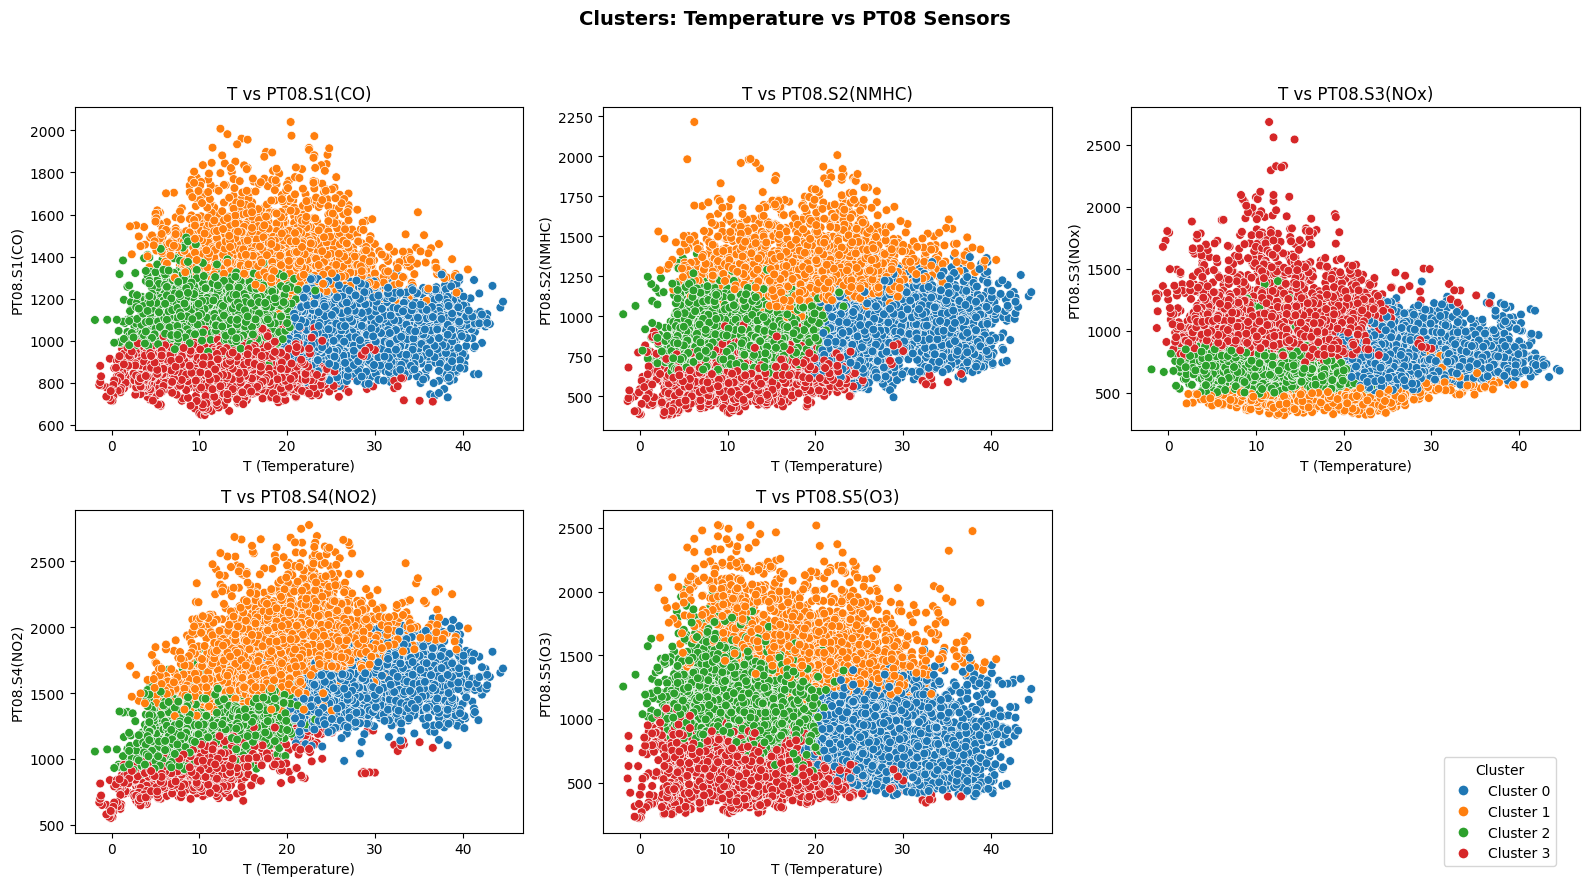

In [106]:
# Side-by-side (2 rows): Temperature vs each PT08 sensor, colored by cluster
from matplotlib.lines import Line2D

sensor_cols = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
rows, cols = 2, 3

fig, axes = plt.subplots(rows, cols, figsize=(16, 9), sharex=False, sharey=False)
axes = np.array(axes).reshape(rows, cols).flatten()

# Plot first 5 sensors across a 2x3 grid (last axis unused)
for ax, sensor in zip(axes, sensor_cols):
    sns.scatterplot(
        data=df_clean,
        x='T', y=sensor,
        hue='cluster', palette='tab10', s=40,
        ax=ax, legend=False
    )
    ax.set_title(f'T vs {sensor}')
    ax.set_xlabel('T (Temperature)')
    ax.set_ylabel(sensor)

# Hide any unused axes (the 6th one)
for ax in axes[len(sensor_cols):]:
    ax.axis('off')

# Build a shared legend (bottom-right to avoid covering the title)
clusters = sorted(df_clean['cluster'].unique())
palette = sns.color_palette('tab10', n_colors=len(clusters))
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {int(c)}',
           markerfacecolor=palette[i], markersize=8)
    for i, c in enumerate(clusters)
]

fig.legend(handles=legend_handles, loc='lower right', ncol=1, title='Cluster', bbox_to_anchor=(0.98, 0.02), frameon=True)
fig.suptitle('Clusters: Temperature vs PT08 Sensors', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [107]:


# Statistical comparison between clusters
print("="*80)
print("CLUSTER INTERPRETATION SUMMARY")
print("="*80)

for cluster_id in sorted(cluster_summary.index):
    print(f"\n{'Cluster ' + str(cluster_id):=^80}")
    print(f"Size: {(labels4 == cluster_id).sum()} observations ({(labels4 == cluster_id).sum()/len(labels4)*100:.1f}%)")
    print(f"\nKey Characteristics:")
    
    cluster_data = cluster_summary.loc[cluster_id]
    overall_mean = cluster_summary.mean()
    
    # Find distinguishing features (>20% different from overall mean)
    distinguishing = []
    for feature in cluster_summary.columns:
        diff_pct = ((cluster_data[feature] - overall_mean[feature]) / overall_mean[feature]) * 100
        if abs(diff_pct) > 20:
            direction = "higher" if diff_pct > 0 else "lower"
            distinguishing.append(f"  • {feature}: {direction} than average ({diff_pct:+.1f}%)")
    
    if distinguishing:
        print("\n".join(distinguishing))
    else:
        print("  • Near-average conditions across all features")
    
    print()

print("="*80)



CLUSTER INTERPRETATION SUMMARY

===================================Cluster 0====================================
Size: 2811 observations (31.3%)

Key Characteristics:
  • T: higher than average (+54.7%)
  • RH: lower than average (-23.8%)
  • AH: higher than average (+28.7%)


===================================Cluster 1====================================
Size: 1846 observations (20.5%)

Key Characteristics:
  • PT08.S1(CO): higher than average (+27.3%)
  • PT08.S2(NMHC): higher than average (+38.6%)
  • PT08.S3(NOx): lower than average (-31.7%)
  • PT08.S4(NO2): higher than average (+27.7%)
  • PT08.S5(O3): higher than average (+50.6%)


===================================Cluster 2====================================
Size: 2176 observations (24.2%)

Key Characteristics:
  • T: lower than average (-33.5%)


===================================Cluster 3====================================
Size: 2158 observations (24.0%)

Key Characteristics:
  • PT08.S1(CO): lower than average (-20.8%)


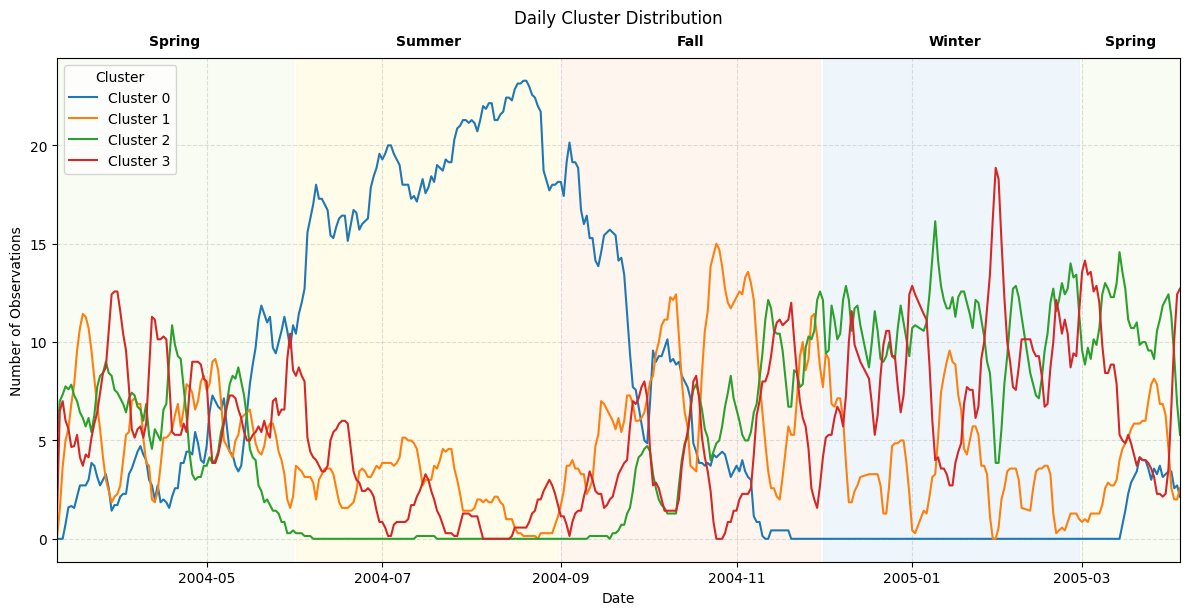

In [108]:
# Ensure datetime exists
df_clean['datetime'] = pd.to_datetime(
    df.loc[df_clean.index, 'Date'] + ' ' + df.loc[df_clean.index, 'Time'], errors='coerce'
)
df_clean = df_clean.dropna(subset=['datetime'])

# Extract date
df_clean['date'] = df_clean['datetime'].dt.date

# Count number of observations per cluster per day
cluster_counts = df_clean.groupby(['date', 'cluster']).size().reset_index(name='count')

# Pivot for rolling average
daily_pivot = cluster_counts.pivot(index='date', columns='cluster', values='count').fillna(0)

# 7-day rolling average
daily_smooth = daily_pivot.rolling(window=7, min_periods=1).mean()

# --- Map months to seasons ---
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

season_map = pd.Series(daily_smooth.index).apply(lambda d: month_to_season(pd.to_datetime(d).month))

# Define neutral pale colors for seasons
season_colors = {'Winter':'#d9eaf7',  # pale blue
                 'Spring':'#f0f8e0',  # pale green
                 'Summer':'#fff9cc',  # pale yellow
                 'Fall':'#ffe6d9'}    # pale peach
alpha_val = 0.4

# --- Prepare season label positions ---
season_positions = []
current_season = season_map.iloc[0]
start_idx = 0

for i, season in enumerate(season_map):
    if season != current_season or i == len(season_map)-1:
        end_idx = i
        mid_idx = (start_idx + end_idx) // 2
        mid_date = daily_smooth.index[mid_idx]
        season_positions.append((mid_date, current_season))
        start_idx = i
        current_season = season

# --- Plot ---
plt.figure(figsize=(12,6))

# Add seasonal shading
current_season = season_map.iloc[0]
start_idx = 0
for i, season in enumerate(season_map):
    if i == 0 or season != season_map.iloc[i-1]:
        start_idx = i
    if i == len(season_map)-1 or season != season_map.iloc[i+1]:
        end_idx = i
        plt.axvspan(daily_smooth.index[start_idx], daily_smooth.index[end_idx],
                    color=season_colors[season_map.iloc[start_idx]], alpha=alpha_val)

# Plot rolling average lines
for cluster in daily_smooth.columns:
    plt.plot(daily_smooth.index, daily_smooth[cluster], marker='', label=f'Cluster {cluster}')

# Add season labels above x-axis
y_max = plt.ylim()[1]
for pos, season in season_positions:
    plt.text(pos, y_max*1.02, season, ha='center', va='bottom', fontsize=10, fontweight='bold')

# Final plot settings
plt.title('Daily Cluster Distribution (7-day Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Number of Observations')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlim(daily_smooth.index.min(), daily_smooth.index.max())
plt.tight_layout()
plt.title('Daily Cluster Distribution', pad=25)
plt.show()

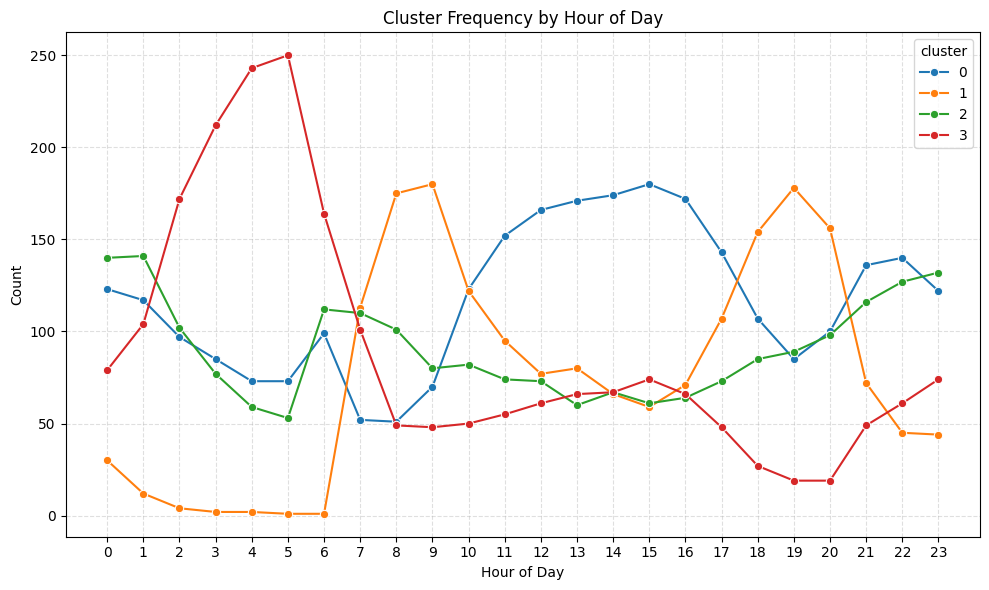

In [109]:
# --- Step 3: Cluster distribution by hour of day ---
df_clean['hour'] = df_clean['datetime'].dt.hour
hourly_dist = df_clean.groupby(['hour', 'cluster']).size().reset_index(name='count')

plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_dist, x='hour', y='count', hue='cluster', marker='o', palette='tab10')
plt.title('Cluster Frequency by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.xticks(range(0,24))
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()